In [1]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [113]:
# Import libraries
import numpy as np
import tensorflow as tf
import os.path
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import GRU, Flatten, Dropout, Dense, BatchNormalization, Activation
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras import optimizers
from keras import metrics
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline
os.chdir('C:\\Users\\anear\\OneDrive - National University of Ireland, Galway\\PhD\\Research Projects\\Ventilation Project')

# Experiment #1: Patients Re-Intubated after 5 Days

Train recurrent neural network models and logistic regression models:
- including patients re-intubated after 5 days as positive outcomes.
- excluding patients re-intubated after 5 days from the analysis completely.
- excluding patients re-intubated after 5 days from the validation/test sets only.

Compare the AUROC the models achieve on their respective test sets.

In [3]:
# Define model architecture
model = Sequential()
model.add(GRU(30, return_sequences=True, input_shape=(24,37)))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(40, activation = "sigmoid"))
model.add(Dropout(0.1))
model.add(Dense(1, activation = "sigmoid"))
model.add(BatchNormalization())
model.add((Activation('sigmoid')))

# Compile model
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=[metrics.BinaryAccuracy(), metrics.AUC()])

# Print model summary
print(model.summary())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 24, 30)            6120      
_________________________________________________________________
flatten_1 (Flatten)          (None, 720)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 720)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                28840     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 41        
__________________________

In [4]:
# Load the data
_data = np.load('data/ML_data.npy', allow_pickle=True).tolist()
X_train = _data['X_24h_train_norm']
reint_train = _data['reint_24h_train']
y_train = _data['y_24h_train']
X_val = _data['X_24h_val_norm']
y_val = _data['y_24h_val']
reint_val = _data['reint_24h_val']
X_test = _data['X_24h_test_norm']
y_test = _data['y_24h_test']
reint_test = _data['reint_24h_test']
print("Loaded!")

Loaded!


In [5]:
# Print information about data
print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of extubation failures in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of extubation failures in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

No. of patients: 8966
No. of patients in train, val, test sets: 7172, 897, 897
No. of extubation failures in train, val, test sets: 2636.0, 325.0, 320.0
Proportion of extubation failures in train, val, test sets: 36.754%, 36.232%, 35.674%


In [6]:
# Remove patients who were re-intubated after 5 days
X_train = X_train[reint_train==0,:,:]
y_train = y_train[reint_train==0]
X_val = X_val[reint_val==0,:,:]
y_val = y_val[reint_val==0]
X_test = X_test[reint_test==0,:,:]
y_test = y_test[reint_test==0]

In [7]:
# Reshape the input tensors so they are in the shape (m,T,n) to fit Keras standards
X_train = np.transpose(X_train, (0,2,1))
X_val = np.transpose(X_val, (0,2,1))
X_test = np.transpose(X_test, (0,2,1))

In [8]:
# Check the shapes of the arrays
print("X_train: {}".format(np.shape(X_train)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val: {}".format(np.shape(X_val)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test: {}".format(np.shape(X_test)))
print("y_test: {}".format(np.shape(y_test)))

X_train: (7090, 24, 37)
y_train: (7090,)
X_val: (889, 24, 37)
y_val: (889,)
X_test: (890, 24, 37)
y_test: (890,)


In [9]:
# Define the early stopping callback
#es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=50, batch_size=32, verbose=1) #, callbacks=[es])


Train on 7090 samples, validate on 889 samples
Epoch 1/50
7090/7090 [==============================] - 3s 458us/step - loss: 0.6815 - binary_accuracy: 0.6000 - auc_1: 0.6313 - val_loss: 0.6534 - val_binary_accuracy: 0.6243 - val_auc_1: 0.7165
Epoch 2/50
7090/7090 [==============================] - 3s 368us/step - loss: 0.6331 - binary_accuracy: 0.6399 - auc_1: 0.6869 - val_loss: 0.5874 - val_binary_accuracy: 0.7019 - val_auc_1: 0.7326
Epoch 3/50
7090/7090 [==============================] - 3s 365us/step - loss: 0.6111 - binary_accuracy: 0.6697 - auc_1: 0.7118 - val_loss: 0.5692 - val_binary_accuracy: 0.7267 - val_auc_1: 0.7438
Epoch 4/50
7090/7090 [==============================] - 3s 365us/step - loss: 0.6026 - binary_accuracy: 0.6829 - auc_1: 0.7189 - val_loss: 0.5635 - val_binary_accuracy: 0.7334 - val_auc_1: 0.7433
Epoch 5/50
7090/7090 [==============================] - 3s 369us/step - loss: 0.5923 - binary_accuracy: 0.6894 - auc_1: 0.7274 - val_loss: 0.5586 - val_binary_accuracy:

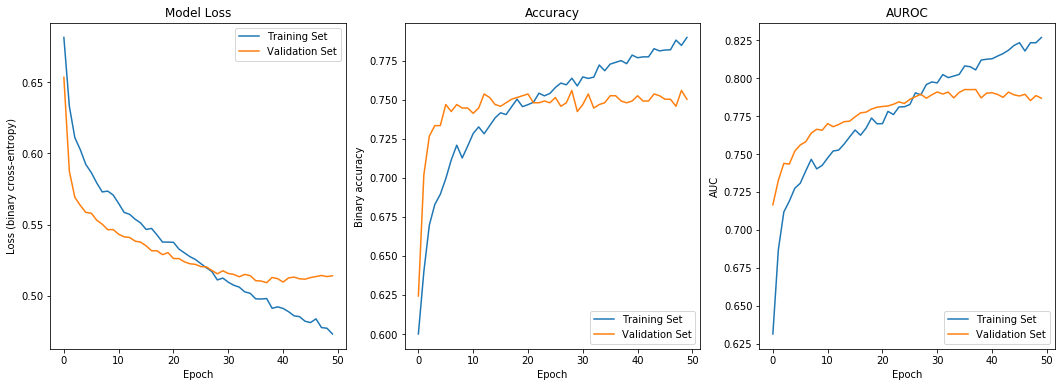

In [10]:
# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(18,6))

# PLot the loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set(title='Model Loss', ylabel='Loss (binary cross-entropy)', xlabel='Epoch')
ax1.legend(['Training Set', 'Validation Set'], loc='upper right')

# Plot the accuracy
ax2.plot(history.history['binary_accuracy'])
ax2.plot(history.history['val_binary_accuracy'])
ax2.set(title='Accuracy', ylabel='Binary accuracy', xlabel='Epoch')
ax2.legend(['Training Set', 'Validation Set'], loc='lower right')

# Plot the AUC
ax3.plot(history.history['auc_1'])
ax3.plot(history.history['val_auc_1'])
ax3.set(title='AUROC', ylabel='AUC', xlabel='Epoch')
ax3.legend(['Training Set', 'Validation Set'], loc='lower right')

#plt.savefig('training.png', bbox_inches='tight')
plt.show()

In [11]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
y_pred_exc = model.predict(X_test).ravel()
fpr_exc, tpr_exc, thresholds = roc_curve(y_test, y_pred_exc)

In [12]:
# Calculate the accuracy and AUROC for the test set using the RNN
from sklearn.metrics import auc
auc_exc = auc(fpr_exc, tpr_exc)

In [13]:
# Load the data
_data = np.load('data/ML_data.npy', allow_pickle=True).tolist()
X_train_raw = _data['X_24h_train']
y_train = _data['y_24h_train']
X_val_raw = _data['X_24h_val']
y_val = _data['y_24h_val']
X_test_raw = _data['X_24h_test']
y_test = _data['y_24h_test']
print("Loaded!")

Loaded!


In [14]:
# Remove patients who were re-intubated after 5 days
X_train_raw = X_train_raw[reint_train==0,:,:]
y_train = y_train[reint_train==0]
X_val_raw = X_val_raw[reint_val==0,:,:]
y_val = y_val[reint_val==0]
X_test_raw = X_test_raw[reint_test==0,:,:]
y_test = y_test[reint_test==0]

In [15]:
# Print information about data
print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of extubation failures in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of extubation failures in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

No. of patients: 8869
No. of patients in train, val, test sets: 7090, 889, 890
No. of extubation failures in train, val, test sets: 2636.0, 325.0, 320.0
Proportion of extubation failures in train, val, test sets: 37.179%, 36.558%, 35.955%


In [16]:
# Check the shapes of the arrays
print("X_train_raw: {}".format(np.shape(X_train_raw)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val_raw: {}".format(np.shape(X_val_raw)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test_raw: {}".format(np.shape(X_test_raw)))
print("y_test: {}".format(np.shape(y_test)))

X_train_raw: (7090, 38, 24)
y_train: (7090,)
X_val_raw: (889, 38, 24)
y_val: (889,)
X_test_raw: (890, 38, 24)
y_test: (890,)


In [17]:
# Prepare training data for non-temporal models
m, n, T = np.shape(X_train_raw)
X_train_static = np.zeros((m,n*4))
for i in range(m):
    for j in range(n):
        feature = X_train_raw[i,j,:]
        extracted_features = [np.min(feature), np.max(feature), np.mean(feature), np.std(feature)]
        X_train_static[i,(j*4):(j*4+4)] = extracted_features
        
# Prepare test data for non-temporal models
m, n, T = np.shape(X_test_raw)
X_test_static = np.zeros((m,n*4))
for i in range(m):
    for j in range(n):
        feature = X_test_raw[i,j,:]
        extracted_features = [np.min(feature), np.max(feature), np.mean(feature), np.std(feature)]
        X_test_static[i,(j*4):(j*4+4)] = extracted_features
        
# Check the shapes of the new arrays
print("X_train_static: {}".format(np.shape(X_train_static)))
print("X_test_static: {}".format(np.shape(X_test_static)))

X_train_static: (7090, 152)
X_test_static: (890, 152)


In [18]:
# Scale the training data using a z-transform, and apply that scaler to the test data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_static)
X_test_scaled = scaler.transform(X_test_static)
print(np.shape(X_train_scaled))

(7090, 152)


In [19]:
# Create logistic regression classifer object
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(solver = "liblinear")

# Train logistic regression classifer
logisticRegr.fit(X_train_scaled, y_train)

# Predict the response for test dataset
y_pred_exc = logisticRegr.predict_proba(X_test_scaled)[:,1]

In [20]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
fpr_exc_lr, tpr_exc_lr, thresholds_exc_lr = roc_curve(y_test, y_pred_exc)

In [21]:
# Calculate the AUROC for the test set
from sklearn.metrics import auc
auc_exc_lr = auc(fpr_exc_lr, tpr_exc_lr)

In [22]:
# Define model architecture
model = Sequential()
model.add(GRU(30, return_sequences=True, input_shape=(24,37)))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(40, activation = "sigmoid"))
model.add(Dropout(0.1))
model.add(Dense(1, activation = "sigmoid"))
model.add(BatchNormalization())
model.add((Activation('sigmoid')))

# Compile model
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=[metrics.BinaryAccuracy(), metrics.AUC()])

# Print model summary
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 24, 30)            6120      
_________________________________________________________________
flatten_2 (Flatten)          (None, 720)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 720)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 40)                28840     
_________________________________________________________________
dropout_4 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 41        
_________________________________________________________________
batch_normalization_2 (Batch (None, 1)                

In [23]:
# Load the data
_data = np.load('data/ML_data.npy', allow_pickle=True).tolist()
X_train = _data['X_24h_train_norm']
reint_train = _data['reint_24h_train']
y_train = _data['y_24h_train']
X_val = _data['X_24h_val_norm']
y_val = _data['y_24h_val']
reint_val = _data['reint_24h_val']
X_test = _data['X_24h_test_norm']
y_test = _data['y_24h_test']
reint_test = _data['reint_24h_test']
print("Loaded!")

Loaded!


In [24]:
# Print information about data
print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of extubation failures in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of extubation failures in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

No. of patients: 8966
No. of patients in train, val, test sets: 7172, 897, 897
No. of extubation failures in train, val, test sets: 2636.0, 325.0, 320.0
Proportion of extubation failures in train, val, test sets: 36.754%, 36.232%, 35.674%


In [25]:
# Reshape the input tensors so they are in the shape (m,T,n) to fit Keras standards
X_train = np.transpose(X_train, (0,2,1))
X_val = np.transpose(X_val, (0,2,1))
X_test = np.transpose(X_test, (0,2,1))

In [26]:
# Check the shapes of the arrays
print("X_train: {}".format(np.shape(X_train)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val: {}".format(np.shape(X_val)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test: {}".format(np.shape(X_test)))
print("y_test: {}".format(np.shape(y_test)))

X_train: (7172, 24, 37)
y_train: (7172,)
X_val: (897, 24, 37)
y_val: (897,)
X_test: (897, 24, 37)
y_test: (897,)


In [27]:
# Define the early stopping callback
#es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=50, batch_size=32, verbose=1) #, callbacks=[es])

Train on 7172 samples, validate on 897 samples
Epoch 1/50
7172/7172 [==============================] - 4s 519us/step - loss: 0.6769 - binary_accuracy: 0.6028 - auc_2: 0.6475 - val_loss: 0.6538 - val_binary_accuracy: 0.6232 - val_auc_2: 0.7262
Epoch 2/50
7172/7172 [==============================] - 3s 423us/step - loss: 0.6289 - binary_accuracy: 0.6411 - auc_2: 0.7000 - val_loss: 0.5903 - val_binary_accuracy: 0.6812 - val_auc_2: 0.7339
Epoch 3/50
7172/7172 [==============================] - 3s 440us/step - loss: 0.6134 - binary_accuracy: 0.6638 - auc_2: 0.7128 - val_loss: 0.5770 - val_binary_accuracy: 0.6923 - val_auc_2: 0.7416
Epoch 4/50
7172/7172 [==============================] - 3s 437us/step - loss: 0.6045 - binary_accuracy: 0.6733 - auc_2: 0.7176 - val_loss: 0.5670 - val_binary_accuracy: 0.7046 - val_auc_2: 0.7476
Epoch 5/50
7172/7172 [==============================] - 3s 413us/step - loss: 0.5936 - binary_accuracy: 0.6877 - auc_2: 0.7283 - val_loss: 0.5643 - val_binary_accuracy: 

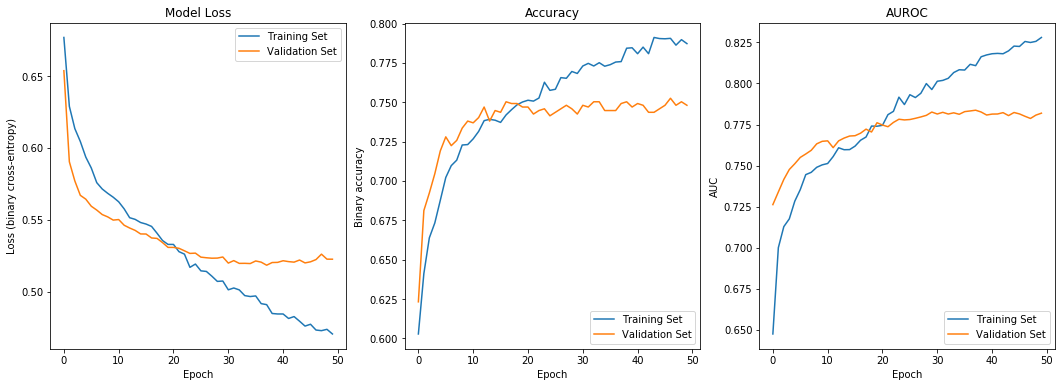

In [28]:
# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(18,6))

# PLot the loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set(title='Model Loss', ylabel='Loss (binary cross-entropy)', xlabel='Epoch')
ax1.legend(['Training Set', 'Validation Set'], loc='upper right')

# Plot the accuracy
ax2.plot(history.history['binary_accuracy'])
ax2.plot(history.history['val_binary_accuracy'])
ax2.set(title='Accuracy', ylabel='Binary accuracy', xlabel='Epoch')
ax2.legend(['Training Set', 'Validation Set'], loc='lower right')

# Plot the AUC
ax3.plot(history.history['auc_2'])
ax3.plot(history.history['val_auc_2'])
ax3.set(title='AUROC', ylabel='AUC', xlabel='Epoch')
ax3.legend(['Training Set', 'Validation Set'], loc='lower right')

#plt.savefig('training.png', bbox_inches='tight')
plt.show()

In [29]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
y_pred_inc = model.predict(X_test).ravel()
fpr_inc, tpr_inc, thresholds = roc_curve(y_test, y_pred_inc)

In [30]:
# Calculate the accuracy and AUROC for the test set using the RNN
from sklearn.metrics import auc
auc_inc = auc(fpr_inc, tpr_inc)

In [31]:
# Define model architecture
model = Sequential()
model.add(GRU(30, return_sequences=True, input_shape=(24,37)))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(40, activation = "sigmoid"))
model.add(Dropout(0.1))
model.add(Dense(1, activation = "sigmoid"))
model.add(BatchNormalization())
model.add((Activation('sigmoid')))

# Compile model
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=[metrics.BinaryAccuracy(), metrics.AUC()])

# Print model summary
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 24, 30)            6120      
_________________________________________________________________
flatten_3 (Flatten)          (None, 720)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 720)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 40)                28840     
_________________________________________________________________
dropout_6 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 41        
_________________________________________________________________
batch_normalization_3 (Batch (None, 1)                

In [32]:
# Load the data
_data = np.load('data/ML_data.npy', allow_pickle=True).tolist()
X_train = _data['X_24h_train_norm']
reint_train = _data['reint_24h_train']
y_train = _data['y_24h_train']
X_val = _data['X_24h_val_norm']
y_val = _data['y_24h_val']
reint_val = _data['reint_24h_val']
X_test = _data['X_24h_test_norm']
y_test = _data['y_24h_test']
reint_test = _data['reint_24h_test']
print("Loaded!")

Loaded!


In [33]:
# Remove patients who were re-intubated after 5 days from val and test sets
X_val = X_val[reint_val==0,:,:]
y_val = y_val[reint_val==0]
X_test = X_test[reint_test==0,:,:]
y_test = y_test[reint_test==0]

In [34]:
# Print information about data
print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of extubation failures in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of extubation failures in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

No. of patients: 8951
No. of patients in train, val, test sets: 7172, 889, 890
No. of extubation failures in train, val, test sets: 2636.0, 325.0, 320.0
Proportion of extubation failures in train, val, test sets: 36.754%, 36.558%, 35.955%


In [35]:
# Reshape the input tensors so they are in the shape (m,T,n) to fit Keras standards
X_train = np.transpose(X_train, (0,2,1))
X_val = np.transpose(X_val, (0,2,1))
X_test = np.transpose(X_test, (0,2,1))

In [36]:
# Check the shapes of the arrays
print("X_train: {}".format(np.shape(X_train)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val: {}".format(np.shape(X_val)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test: {}".format(np.shape(X_test)))
print("y_test: {}".format(np.shape(y_test)))

X_train: (7172, 24, 37)
y_train: (7172,)
X_val: (889, 24, 37)
y_val: (889,)
X_test: (890, 24, 37)
y_test: (890,)


In [37]:
# Define the early stopping callback
#es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=50, batch_size=32, verbose=1) #, callbacks=[es])

Train on 7172 samples, validate on 889 samples
Epoch 1/50
7172/7172 [==============================] - 4s 492us/step - loss: 0.6680 - binary_accuracy: 0.6121 - auc_3: 0.6602 - val_loss: 0.6524 - val_binary_accuracy: 0.6018 - val_auc_3: 0.7255
Epoch 2/50
7172/7172 [==============================] - 3s 431us/step - loss: 0.6216 - binary_accuracy: 0.6509 - auc_3: 0.7080 - val_loss: 0.5880 - val_binary_accuracy: 0.6985 - val_auc_3: 0.7347
Epoch 3/50
7172/7172 [==============================] - 3s 453us/step - loss: 0.6080 - binary_accuracy: 0.6672 - auc_3: 0.7211 - val_loss: 0.5712 - val_binary_accuracy: 0.7075 - val_auc_3: 0.7437
Epoch 4/50
7172/7172 [==============================] - 3s 418us/step - loss: 0.5993 - binary_accuracy: 0.6786 - auc_3: 0.7273 - val_loss: 0.5642 - val_binary_accuracy: 0.7188 - val_auc_3: 0.7502
Epoch 5/50
7172/7172 [==============================] - 3s 442us/step - loss: 0.5925 - binary_accuracy: 0.6866 - auc_3: 0.7308 - val_loss: 0.5594 - val_binary_accuracy: 

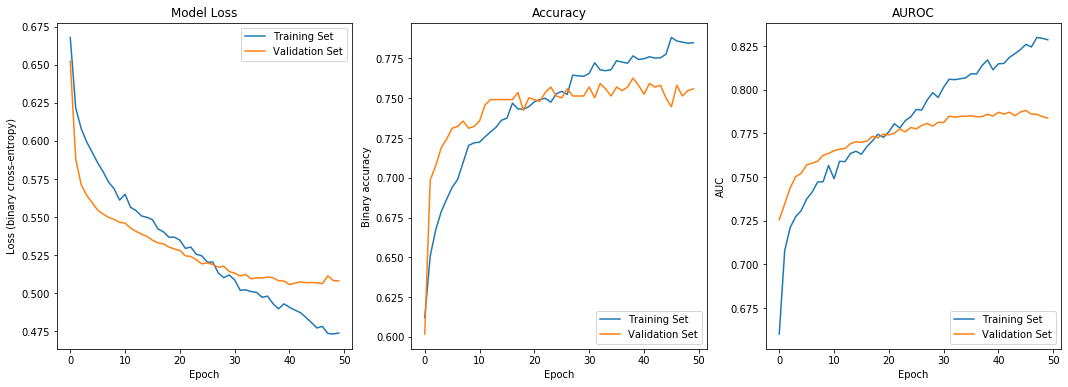

In [38]:
# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(18,6))

# PLot the loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set(title='Model Loss', ylabel='Loss (binary cross-entropy)', xlabel='Epoch')
ax1.legend(['Training Set', 'Validation Set'], loc='upper right')

# Plot the accuracy
ax2.plot(history.history['binary_accuracy'])
ax2.plot(history.history['val_binary_accuracy'])
ax2.set(title='Accuracy', ylabel='Binary accuracy', xlabel='Epoch')
ax2.legend(['Training Set', 'Validation Set'], loc='lower right')

# Plot the AUC
ax3.plot(history.history['auc_3'])
ax3.plot(history.history['val_auc_3'])
ax3.set(title='AUROC', ylabel='AUC', xlabel='Epoch')
ax3.legend(['Training Set', 'Validation Set'], loc='lower right')

#plt.savefig('training.png', bbox_inches='tight')
plt.show()

In [39]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
y_pred_inc_alt = model.predict(X_test).ravel()
fpr_inc_alt, tpr_inc_alt, thresholds = roc_curve(y_test, y_pred_inc_alt)

In [40]:
# Calculate the accuracy and AUROC for the test set using the RNN
from sklearn.metrics import auc
auc_inc_alt = auc(fpr_inc_alt, tpr_inc_alt)

In [41]:
# Load the data
_data = np.load('data/ML_data.npy', allow_pickle=True).tolist()
X_train_raw = _data['X_24h_train']
y_train = _data['y_24h_train']
X_val_raw = _data['X_24h_val']
y_val = _data['y_24h_val']
X_test_raw = _data['X_24h_test']
y_test = _data['y_24h_test']
print("Loaded!")

Loaded!


In [42]:
# Print information about data
print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of extubation failures in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of extubation failures in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

No. of patients: 8966
No. of patients in train, val, test sets: 7172, 889, 890
No. of extubation failures in train, val, test sets: 2636.0, 325.0, 320.0
Proportion of extubation failures in train, val, test sets: 36.754%, 36.232%, 35.674%


In [43]:
# Check the shapes of the arrays
print("X_train_raw: {}".format(np.shape(X_train_raw)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val_raw: {}".format(np.shape(X_val_raw)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test_raw: {}".format(np.shape(X_test_raw)))
print("y_test: {}".format(np.shape(y_test)))

X_train_raw: (7172, 38, 24)
y_train: (7172,)
X_val_raw: (897, 38, 24)
y_val: (897,)
X_test_raw: (897, 38, 24)
y_test: (897,)


In [44]:
# Prepare training data for non-temporal models
m, n, T = np.shape(X_train_raw)
X_train_static = np.zeros((m,n*4))
for i in range(m):
    for j in range(n):
        feature = X_train_raw[i,j,:]
        extracted_features = [np.min(feature), np.max(feature), np.mean(feature), np.std(feature)]
        X_train_static[i,(j*4):(j*4+4)] = extracted_features
        
# Prepare test data for non-temporal models
m, n, T = np.shape(X_test_raw)
X_test_static = np.zeros((m,n*4))
for i in range(m):
    for j in range(n):
        feature = X_test_raw[i,j,:]
        extracted_features = [np.min(feature), np.max(feature), np.mean(feature), np.std(feature)]
        X_test_static[i,(j*4):(j*4+4)] = extracted_features
        
# Check the shapes of the new arrays
print("X_train_static: {}".format(np.shape(X_train_static)))
print("X_test_static: {}".format(np.shape(X_test_static)))

X_train_static: (7172, 152)
X_test_static: (897, 152)


In [45]:
# Scale the training data using a z-transform, and apply that scaler to the test data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_static)
X_test_scaled = scaler.transform(X_test_static)
print(np.shape(X_train_scaled))

(7172, 152)


In [46]:
# Create logistic regression classifer object
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(solver = "liblinear")

# Train logistic regression classifer
logisticRegr.fit(X_train_scaled, y_train)

# Predict the response for test dataset
y_pred_inc = logisticRegr.predict_proba(X_test_scaled)[:,1]

In [47]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
fpr_inc_lr, tpr_inc_lr, thresholds_inc_lr = roc_curve(y_test, y_pred_inc)

In [48]:
# Calculate the AUROC for the test set
from sklearn.metrics import auc
auc_inc_lr = auc(fpr_inc_lr, tpr_inc_lr)

In [49]:
# Load the data
_data = np.load('data/ML_data.npy', allow_pickle=True).tolist()
X_train_raw = _data['X_24h_train']
y_train = _data['y_24h_train']
X_val_raw = _data['X_24h_val']
y_val = _data['y_24h_val']
X_test_raw = _data['X_24h_test']
y_test = _data['y_24h_test']
print("Loaded!")

Loaded!


In [50]:
# Remove patients who were re-intubated after 5 days from val and test sets
X_val_raw = X_val_raw[reint_val==0,:,:]
y_val = y_val[reint_val==0]
X_test_raw = X_test_raw[reint_test==0,:,:]
y_test = y_test[reint_test==0]

In [51]:
# Print information about data
print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of extubation failures in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of extubation failures in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

No. of patients: 8951
No. of patients in train, val, test sets: 7172, 889, 890
No. of extubation failures in train, val, test sets: 2636.0, 325.0, 320.0
Proportion of extubation failures in train, val, test sets: 36.754%, 36.558%, 35.955%


In [52]:
# Check the shapes of the arrays
print("X_train_raw: {}".format(np.shape(X_train_raw)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val_raw: {}".format(np.shape(X_val_raw)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test_raw: {}".format(np.shape(X_test_raw)))
print("y_test: {}".format(np.shape(y_test)))

X_train_raw: (7172, 38, 24)
y_train: (7172,)
X_val_raw: (889, 38, 24)
y_val: (889,)
X_test_raw: (890, 38, 24)
y_test: (890,)


In [53]:
# Prepare training data for non-temporal models
m, n, T = np.shape(X_train_raw)
X_train_static = np.zeros((m,n*4))
for i in range(m):
    for j in range(n):
        feature = X_train_raw[i,j,:]
        extracted_features = [np.min(feature), np.max(feature), np.mean(feature), np.std(feature)]
        X_train_static[i,(j*4):(j*4+4)] = extracted_features
        
# Prepare test data for non-temporal models
m, n, T = np.shape(X_test_raw)
X_test_static = np.zeros((m,n*4))
for i in range(m):
    for j in range(n):
        feature = X_test_raw[i,j,:]
        extracted_features = [np.min(feature), np.max(feature), np.mean(feature), np.std(feature)]
        X_test_static[i,(j*4):(j*4+4)] = extracted_features
        
# Check the shapes of the new arrays
print("X_train_static: {}".format(np.shape(X_train_static)))
print("X_test_static: {}".format(np.shape(X_test_static)))

X_train_static: (7172, 152)
X_test_static: (890, 152)


In [54]:
# Scale the training data using a z-transform, and apply that scaler to the test data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_static)
X_test_scaled = scaler.transform(X_test_static)
print(np.shape(X_train_scaled))

(7172, 152)


In [55]:
# Create logistic regression classifer object
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(solver = "liblinear")

# Train logistic regression classifer
logisticRegr.fit(X_train_scaled, y_train)

# Predict the response for test dataset
y_pred_inc_alt = logisticRegr.predict_proba(X_test_scaled)[:,1]

In [56]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
fpr_inc_alt_lr, tpr_inc_alt_lr, thresholds_inc_alt_lr = roc_curve(y_test, y_pred_inc_alt)

In [57]:
# Calculate the AUROC for the test set
from sklearn.metrics import auc
auc_inc_alt_lr = auc(fpr_inc_alt_lr, tpr_inc_alt_lr)

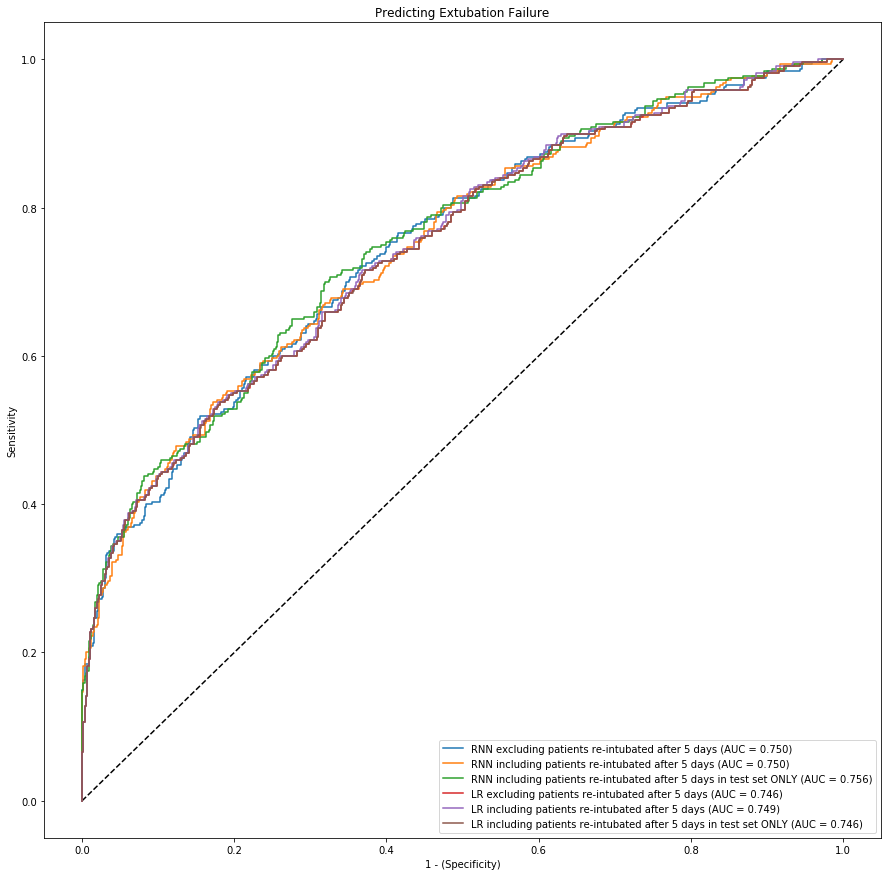

In [58]:
# Compare ROC curves
plt.figure(figsize=(15,15))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_exc, tpr_exc, label='RNN excluding patients re-intubated after 5 days (AUC = {:.3f})'.format(auc_exc), ls='-')
plt.plot(fpr_inc, tpr_inc, label='RNN including patients re-intubated after 5 days (AUC = {:.3f})'.format(auc_inc), ls='-')
plt.plot(fpr_inc_alt, tpr_inc_alt, label='RNN including patients re-intubated after 5 days in test set ONLY (AUC = {:.3f})'.format(auc_inc_alt), ls='-')
plt.plot(fpr_exc_lr, tpr_exc_lr, label='LR excluding patients re-intubated after 5 days (AUC = {:.3f})'.format(auc_exc_lr), ls='-')
plt.plot(fpr_inc_lr, tpr_inc_lr, label='LR including patients re-intubated after 5 days (AUC = {:.3f})'.format(auc_inc_lr), ls='-')
plt.plot(fpr_inc_alt_lr, tpr_inc_alt_lr, label='LR including patients re-intubated after 5 days in test set ONLY (AUC = {:.3f})'.format(auc_inc_alt_lr), ls='-')
plt.xlabel('1 - (Specificity)')
plt.ylabel('Sensitivity')
plt.title('Predicting Extubation Failure')
plt.legend(loc='lower right')
plt.savefig('plots/roc_curves.png', bbox_inches='tight')
plt.show()

# Experiment #2: Dropout

Train and test recurrent neural network models with varying levels of droupout

Compare the AUROC the models achieve.

In [59]:
# Specify dropout
dropout = 0.0

# Define model architecture
model = Sequential()
model.add(GRU(30, return_sequences=True, input_shape=(24,37)))
model.add(Flatten())
model.add(Dropout(dropout))
model.add(Dense(40, activation = "sigmoid"))
model.add(Dropout(dropout))
model.add(Dense(1, activation = "sigmoid"))
model.add(BatchNormalization())
model.add((Activation('sigmoid')))

# Compile model
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=[metrics.BinaryAccuracy(), metrics.AUC()])

# Print model summary
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 24, 30)            6120      
_________________________________________________________________
flatten_4 (Flatten)          (None, 720)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 720)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 40)                28840     
_________________________________________________________________
dropout_8 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 41        
_________________________________________________________________
batch_normalization_4 (Batch (None, 1)                

In [60]:
# Load the data
_data = np.load('data/ML_data.npy', allow_pickle=True).tolist()
X_train = _data['X_24h_train_norm']
reint_train = _data['reint_24h_train']
y_train = _data['y_24h_train']
X_val = _data['X_24h_val_norm']
y_val = _data['y_24h_val']
reint_val = _data['reint_24h_val']
X_test = _data['X_24h_test_norm']
y_test = _data['y_24h_test']
reint_test = _data['reint_24h_test']
print("Loaded!")

Loaded!


In [61]:
# Print information about data
print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of extubation failures in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of extubation failures in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

No. of patients: 8966
No. of patients in train, val, test sets: 7172, 897, 897
No. of extubation failures in train, val, test sets: 2636.0, 325.0, 320.0
Proportion of extubation failures in train, val, test sets: 36.754%, 36.232%, 35.674%


In [62]:
# Reshape the input tensors so they are in the shape (m,T,n) to fit Keras standards
X_train = np.transpose(X_train, (0,2,1))
X_val = np.transpose(X_val, (0,2,1))
X_test = np.transpose(X_test, (0,2,1))

In [63]:
# Check the shapes of the arrays
print("X_train: {}".format(np.shape(X_train)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val: {}".format(np.shape(X_val)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test: {}".format(np.shape(X_test)))
print("y_test: {}".format(np.shape(y_test)))

X_train: (7172, 24, 37)
y_train: (7172,)
X_val: (897, 24, 37)
y_val: (897,)
X_test: (897, 24, 37)
y_test: (897,)


In [64]:
# Define the early stopping callback
#es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=50, batch_size=32, verbose=1) #, callbacks=[es])

Train on 7172 samples, validate on 897 samples
Epoch 1/50
7172/7172 [==============================] - 3s 421us/step - loss: 0.6365 - binary_accuracy: 0.6355 - auc_4: 0.6718 - val_loss: 0.6736 - val_binary_accuracy: 0.5875 - val_auc_4: 0.7390
Epoch 2/50
7172/7172 [==============================] - 3s 373us/step - loss: 0.5993 - binary_accuracy: 0.6831 - auc_4: 0.7227 - val_loss: 0.6081 - val_binary_accuracy: 0.7213 - val_auc_4: 0.7478
Epoch 3/50
7172/7172 [==============================] - 3s 349us/step - loss: 0.5912 - binary_accuracy: 0.6893 - auc_4: 0.7333 - val_loss: 0.5722 - val_binary_accuracy: 0.7347 - val_auc_4: 0.7589
Epoch 4/50
7172/7172 [==============================] - 3s 375us/step - loss: 0.5796 - binary_accuracy: 0.7048 - auc_4: 0.7459 - val_loss: 0.5643 - val_binary_accuracy: 0.7302 - val_auc_4: 0.7645
Epoch 5/50
7172/7172 [==============================] - 3s 355us/step - loss: 0.5749 - binary_accuracy: 0.7082 - auc_4: 0.7531 - val_loss: 0.5601 - val_binary_accuracy: 

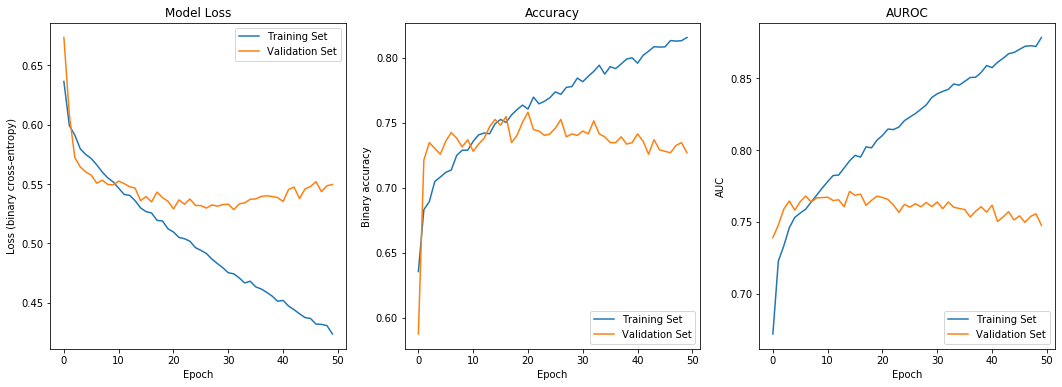

In [65]:
# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(18,6))

# PLot the loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set(title='Model Loss', ylabel='Loss (binary cross-entropy)', xlabel='Epoch')
ax1.legend(['Training Set', 'Validation Set'], loc='upper right')

# Plot the accuracy
ax2.plot(history.history['binary_accuracy'])
ax2.plot(history.history['val_binary_accuracy'])
ax2.set(title='Accuracy', ylabel='Binary accuracy', xlabel='Epoch')
ax2.legend(['Training Set', 'Validation Set'], loc='lower right')

# Plot the AUC
ax3.plot(history.history['auc_4'])
ax3.plot(history.history['val_auc_4'])
ax3.set(title='AUROC', ylabel='AUC', xlabel='Epoch')
ax3.legend(['Training Set', 'Validation Set'], loc='lower right')

#plt.savefig('training.png', bbox_inches='tight')
plt.show()

In [66]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
y_pred_0 = model.predict(X_test).ravel()
fpr_0, tpr_0, thresholds = roc_curve(y_test, y_pred_0)

In [67]:
# Calculate the accuracy and AUROC for the test set using the RNN
from sklearn.metrics import auc
auc_0 = auc(fpr_0, tpr_0)

In [68]:
# Specify dropout
dropout = 0.2

# Define model architecture
model = Sequential()
model.add(GRU(30, return_sequences=True, input_shape=(24,37)))
model.add(Flatten())
model.add(Dropout(dropout))
model.add(Dense(40, activation = "sigmoid"))
model.add(Dropout(dropout))
model.add(Dense(1, activation = "sigmoid"))
model.add(BatchNormalization())
model.add((Activation('sigmoid')))

# Compile model
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=[metrics.BinaryAccuracy(), metrics.AUC()])

# Print model summary
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, 24, 30)            6120      
_________________________________________________________________
flatten_5 (Flatten)          (None, 720)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 720)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 40)                28840     
_________________________________________________________________
dropout_10 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 41        
_________________________________________________________________
batch_normalization_5 (Batch (None, 1)                

In [69]:
# Load the data
_data = np.load('data/ML_data.npy', allow_pickle=True).tolist()
X_train = _data['X_24h_train_norm']
reint_train = _data['reint_24h_train']
y_train = _data['y_24h_train']
X_val = _data['X_24h_val_norm']
y_val = _data['y_24h_val']
reint_val = _data['reint_24h_val']
X_test = _data['X_24h_test_norm']
y_test = _data['y_24h_test']
reint_test = _data['reint_24h_test']
print("Loaded!")

Loaded!


In [70]:
# Print information about data
print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of extubation failures in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of extubation failures in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

No. of patients: 8966
No. of patients in train, val, test sets: 7172, 897, 897
No. of extubation failures in train, val, test sets: 2636.0, 325.0, 320.0
Proportion of extubation failures in train, val, test sets: 36.754%, 36.232%, 35.674%


In [71]:
# Reshape the input tensors so they are in the shape (m,T,n) to fit Keras standards
X_train = np.transpose(X_train, (0,2,1))
X_val = np.transpose(X_val, (0,2,1))
X_test = np.transpose(X_test, (0,2,1))

In [72]:
# Check the shapes of the arrays
print("X_train: {}".format(np.shape(X_train)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val: {}".format(np.shape(X_val)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test: {}".format(np.shape(X_test)))
print("y_test: {}".format(np.shape(y_test)))

X_train: (7172, 24, 37)
y_train: (7172,)
X_val: (897, 24, 37)
y_val: (897,)
X_test: (897, 24, 37)
y_test: (897,)


In [73]:
# Define the early stopping callback
#es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=50, batch_size=32, verbose=1) #, callbacks=[es])

Train on 7172 samples, validate on 897 samples
Epoch 1/50
7172/7172 [==============================] - 3s 467us/step - loss: 0.6924 - binary_accuracy: 0.5864 - auc_5: 0.6322 - val_loss: 0.6448 - val_binary_accuracy: 0.6143 - val_auc_5: 0.7227
Epoch 2/50
7172/7172 [==============================] - 3s 393us/step - loss: 0.6463 - binary_accuracy: 0.6287 - auc_5: 0.6845 - val_loss: 0.5880 - val_binary_accuracy: 0.7012 - val_auc_5: 0.7370
Epoch 3/50
7172/7172 [==============================] - 3s 371us/step - loss: 0.6297 - binary_accuracy: 0.6456 - auc_5: 0.6987 - val_loss: 0.5743 - val_binary_accuracy: 0.7179 - val_auc_5: 0.7450
Epoch 4/50
7172/7172 [==============================] - 3s 378us/step - loss: 0.6178 - binary_accuracy: 0.6654 - auc_5: 0.7050 - val_loss: 0.5655 - val_binary_accuracy: 0.7258 - val_auc_5: 0.7476
Epoch 5/50
7172/7172 [==============================] - 3s 392us/step - loss: 0.6052 - binary_accuracy: 0.6814 - auc_5: 0.7156 - val_loss: 0.5601 - val_binary_accuracy: 

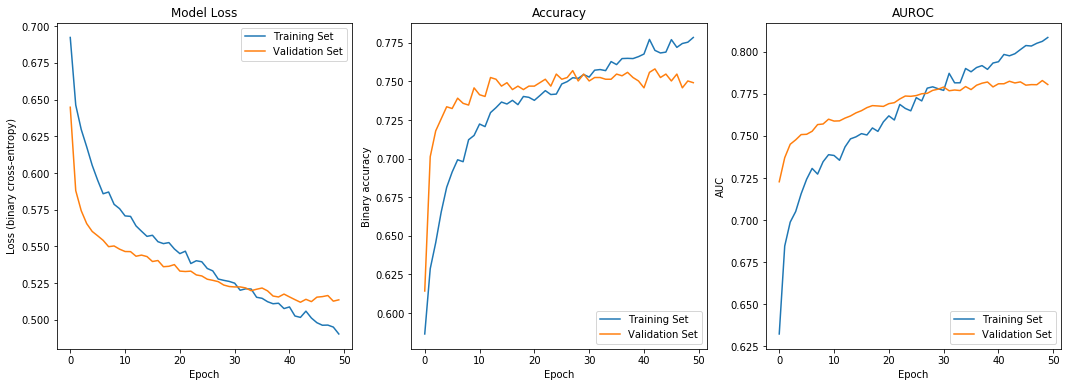

In [74]:
# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(18,6))

# PLot the loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set(title='Model Loss', ylabel='Loss (binary cross-entropy)', xlabel='Epoch')
ax1.legend(['Training Set', 'Validation Set'], loc='upper right')

# Plot the accuracy
ax2.plot(history.history['binary_accuracy'])
ax2.plot(history.history['val_binary_accuracy'])
ax2.set(title='Accuracy', ylabel='Binary accuracy', xlabel='Epoch')
ax2.legend(['Training Set', 'Validation Set'], loc='lower right')

# Plot the AUC
ax3.plot(history.history['auc_5'])
ax3.plot(history.history['val_auc_5'])
ax3.set(title='AUROC', ylabel='AUC', xlabel='Epoch')
ax3.legend(['Training Set', 'Validation Set'], loc='lower right')

#plt.savefig('training.png', bbox_inches='tight')
plt.show()

In [75]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
y_pred_20 = model.predict(X_test).ravel()
fpr_20, tpr_20, thresholds = roc_curve(y_test, y_pred_20)

In [76]:
# Calculate the accuracy and AUROC for the test set using the RNN
from sklearn.metrics import auc
auc_20 = auc(fpr_20, tpr_20)

In [77]:
# Specify dropout
dropout = 0.4

# Define model architecture
model = Sequential()
model.add(GRU(30, return_sequences=True, input_shape=(24,37)))
model.add(Flatten())
model.add(Dropout(dropout))
model.add(Dense(40, activation = "sigmoid"))
model.add(Dropout(dropout))
model.add(Dense(1, activation = "sigmoid"))
model.add(BatchNormalization())
model.add((Activation('sigmoid')))

# Compile model
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=[metrics.BinaryAccuracy(), metrics.AUC()])

# Print model summary
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 24, 30)            6120      
_________________________________________________________________
flatten_6 (Flatten)          (None, 720)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 720)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 40)                28840     
_________________________________________________________________
dropout_12 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 41        
_________________________________________________________________
batch_normalization_6 (Batch (None, 1)                

In [78]:
# Load the data
_data = np.load('data/ML_data.npy', allow_pickle=True).tolist()
X_train = _data['X_24h_train_norm']
reint_train = _data['reint_24h_train']
y_train = _data['y_24h_train']
X_val = _data['X_24h_val_norm']
y_val = _data['y_24h_val']
reint_val = _data['reint_24h_val']
X_test = _data['X_24h_test_norm']
y_test = _data['y_24h_test']
reint_test = _data['reint_24h_test']
print("Loaded!")

Loaded!


In [79]:
# Print information about data
print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of extubation failures in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of extubation failures in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

No. of patients: 8966
No. of patients in train, val, test sets: 7172, 897, 897
No. of extubation failures in train, val, test sets: 2636.0, 325.0, 320.0
Proportion of extubation failures in train, val, test sets: 36.754%, 36.232%, 35.674%


In [80]:
# Reshape the input tensors so they are in the shape (m,T,n) to fit Keras standards
X_train = np.transpose(X_train, (0,2,1))
X_val = np.transpose(X_val, (0,2,1))
X_test = np.transpose(X_test, (0,2,1))

In [81]:
# Check the shapes of the arrays
print("X_train: {}".format(np.shape(X_train)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val: {}".format(np.shape(X_val)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test: {}".format(np.shape(X_test)))
print("y_test: {}".format(np.shape(y_test)))

X_train: (7172, 24, 37)
y_train: (7172,)
X_val: (897, 24, 37)
y_val: (897,)
X_test: (897, 24, 37)
y_test: (897,)


In [82]:
# Define the early stopping callback
#es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=50, batch_size=32, verbose=1) #, callbacks=[es])

Train on 7172 samples, validate on 897 samples
Epoch 1/50
7172/7172 [==============================] - 4s 589us/step - loss: 0.7250 - binary_accuracy: 0.5654 - auc_6: 0.5892 - val_loss: 0.6363 - val_binary_accuracy: 0.6410 - val_auc_6: 0.7044
Epoch 2/50
7172/7172 [==============================] - 4s 515us/step - loss: 0.6615 - binary_accuracy: 0.6263 - auc_6: 0.6590 - val_loss: 0.5868 - val_binary_accuracy: 0.6934 - val_auc_6: 0.7224
Epoch 3/50
7172/7172 [==============================] - 4s 527us/step - loss: 0.6442 - binary_accuracy: 0.6457 - auc_6: 0.6745 - val_loss: 0.5733 - val_binary_accuracy: 0.7068 - val_auc_6: 0.7313
Epoch 4/50
7172/7172 [==============================] - 3s 486us/step - loss: 0.6227 - binary_accuracy: 0.6649 - auc_6: 0.6941 - val_loss: 0.5659 - val_binary_accuracy: 0.7135 - val_auc_6: 0.7374
Epoch 5/50
7172/7172 [==============================] - 3s 418us/step - loss: 0.6163 - binary_accuracy: 0.6732 - auc_6: 0.6978 - val_loss: 0.5596 - val_binary_accuracy: 

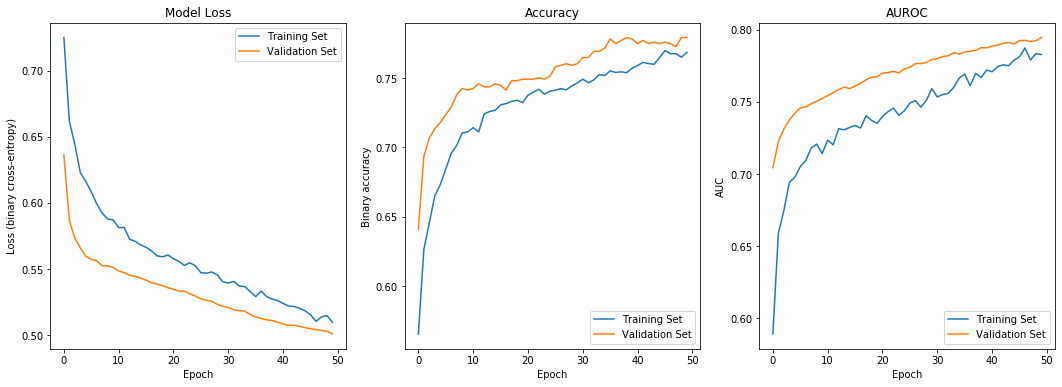

In [83]:
# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(18,6))

# PLot the loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set(title='Model Loss', ylabel='Loss (binary cross-entropy)', xlabel='Epoch')
ax1.legend(['Training Set', 'Validation Set'], loc='upper right')

# Plot the accuracy
ax2.plot(history.history['binary_accuracy'])
ax2.plot(history.history['val_binary_accuracy'])
ax2.set(title='Accuracy', ylabel='Binary accuracy', xlabel='Epoch')
ax2.legend(['Training Set', 'Validation Set'], loc='lower right')

# Plot the AUC
ax3.plot(history.history['auc_6'])
ax3.plot(history.history['val_auc_6'])
ax3.set(title='AUROC', ylabel='AUC', xlabel='Epoch')
ax3.legend(['Training Set', 'Validation Set'], loc='lower right')

#plt.savefig('training.png', bbox_inches='tight')
plt.show()

In [84]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
y_pred_40 = model.predict(X_test).ravel()
fpr_40, tpr_40, thresholds = roc_curve(y_test, y_pred_40)

In [85]:
# Calculate the accuracy and AUROC for the test set using the RNN
from sklearn.metrics import auc
auc_40 = auc(fpr_40, tpr_40)

In [86]:
# Specify dropout
dropout = 0.6

# Define model architecture
model = Sequential()
model.add(GRU(30, return_sequences=True, input_shape=(24,37)))
model.add(Flatten())
model.add(Dropout(dropout))
model.add(Dense(40, activation = "sigmoid"))
model.add(Dropout(dropout))
model.add(Dense(1, activation = "sigmoid"))
model.add(BatchNormalization())
model.add((Activation('sigmoid')))

# Compile model
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=[metrics.BinaryAccuracy(), metrics.AUC()])

# Print model summary
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (None, 24, 30)            6120      
_________________________________________________________________
flatten_7 (Flatten)          (None, 720)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 720)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 40)                28840     
_________________________________________________________________
dropout_14 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 41        
_________________________________________________________________
batch_normalization_7 (Batch (None, 1)                

In [87]:
# Load the data
_data = np.load('data/ML_data.npy', allow_pickle=True).tolist()
X_train = _data['X_24h_train_norm']
reint_train = _data['reint_24h_train']
y_train = _data['y_24h_train']
X_val = _data['X_24h_val_norm']
y_val = _data['y_24h_val']
reint_val = _data['reint_24h_val']
X_test = _data['X_24h_test_norm']
y_test = _data['y_24h_test']
reint_test = _data['reint_24h_test']
print("Loaded!")

Loaded!


In [88]:
# Print information about data
print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of extubation failures in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of extubation failures in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

No. of patients: 8966
No. of patients in train, val, test sets: 7172, 897, 897
No. of extubation failures in train, val, test sets: 2636.0, 325.0, 320.0
Proportion of extubation failures in train, val, test sets: 36.754%, 36.232%, 35.674%


In [89]:
# Reshape the input tensors so they are in the shape (m,T,n) to fit Keras standards
X_train = np.transpose(X_train, (0,2,1))
X_val = np.transpose(X_val, (0,2,1))
X_test = np.transpose(X_test, (0,2,1))

In [90]:
# Check the shapes of the arrays
print("X_train: {}".format(np.shape(X_train)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val: {}".format(np.shape(X_val)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test: {}".format(np.shape(X_test)))
print("y_test: {}".format(np.shape(y_test)))

X_train: (7172, 24, 37)
y_train: (7172,)
X_val: (897, 24, 37)
y_val: (897,)
X_test: (897, 24, 37)
y_test: (897,)


In [91]:
# Define the early stopping callback
#es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=50, batch_size=32, verbose=1) #, callbacks=[es])

Train on 7172 samples, validate on 897 samples
Epoch 1/50
7172/7172 [==============================] - 3s 461us/step - loss: 0.7559 - binary_accuracy: 0.5534 - auc_7: 0.5558 - val_loss: 0.6500 - val_binary_accuracy: 0.6355 - val_auc_7: 0.6757
Epoch 2/50
7172/7172 [==============================] - 3s 366us/step - loss: 0.6979 - binary_accuracy: 0.5986 - auc_7: 0.6166 - val_loss: 0.5970 - val_binary_accuracy: 0.6722 - val_auc_7: 0.6993
Epoch 3/50
7172/7172 [==============================] - 3s 379us/step - loss: 0.6631 - binary_accuracy: 0.6274 - auc_7: 0.6503 - val_loss: 0.5794 - val_binary_accuracy: 0.7057 - val_auc_7: 0.7146
Epoch 4/50
7172/7172 [==============================] - 3s 392us/step - loss: 0.6399 - binary_accuracy: 0.6537 - auc_7: 0.6776 - val_loss: 0.5736 - val_binary_accuracy: 0.7168 - val_auc_7: 0.7230
Epoch 5/50
7172/7172 [==============================] - 3s 374us/step - loss: 0.6338 - binary_accuracy: 0.6655 - auc_7: 0.6754 - val_loss: 0.5675 - val_binary_accuracy: 

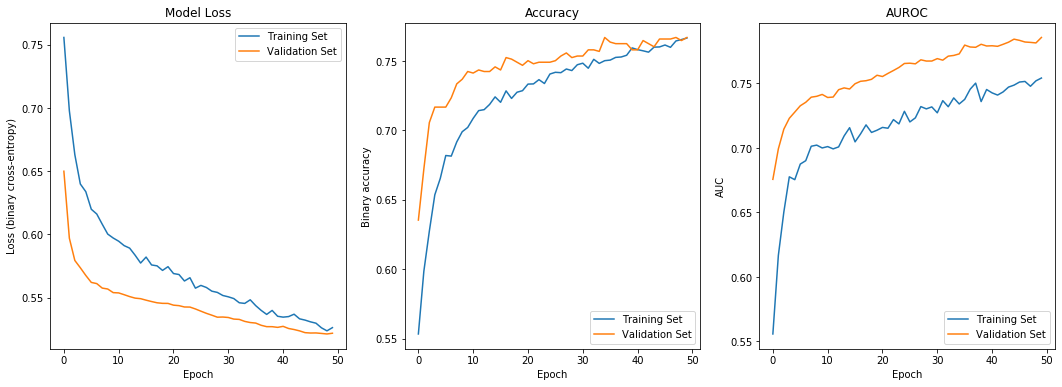

In [93]:
# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(18,6))

# PLot the loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set(title='Model Loss', ylabel='Loss (binary cross-entropy)', xlabel='Epoch')
ax1.legend(['Training Set', 'Validation Set'], loc='upper right')

# Plot the accuracy
ax2.plot(history.history['binary_accuracy'])
ax2.plot(history.history['val_binary_accuracy'])
ax2.set(title='Accuracy', ylabel='Binary accuracy', xlabel='Epoch')
ax2.legend(['Training Set', 'Validation Set'], loc='lower right')

# Plot the AUC
ax3.plot(history.history['auc_7'])
ax3.plot(history.history['val_auc_7'])
ax3.set(title='AUROC', ylabel='AUC', xlabel='Epoch')
ax3.legend(['Training Set', 'Validation Set'], loc='lower right')

#plt.savefig('training.png', bbox_inches='tight')
plt.show()

In [94]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
y_pred_60 = model.predict(X_test).ravel()
fpr_60, tpr_60, thresholds = roc_curve(y_test, y_pred_60)

In [95]:
# Calculate the accuracy and AUROC for the test set using the RNN
from sklearn.metrics import auc
auc_60 = auc(fpr_60, tpr_60)

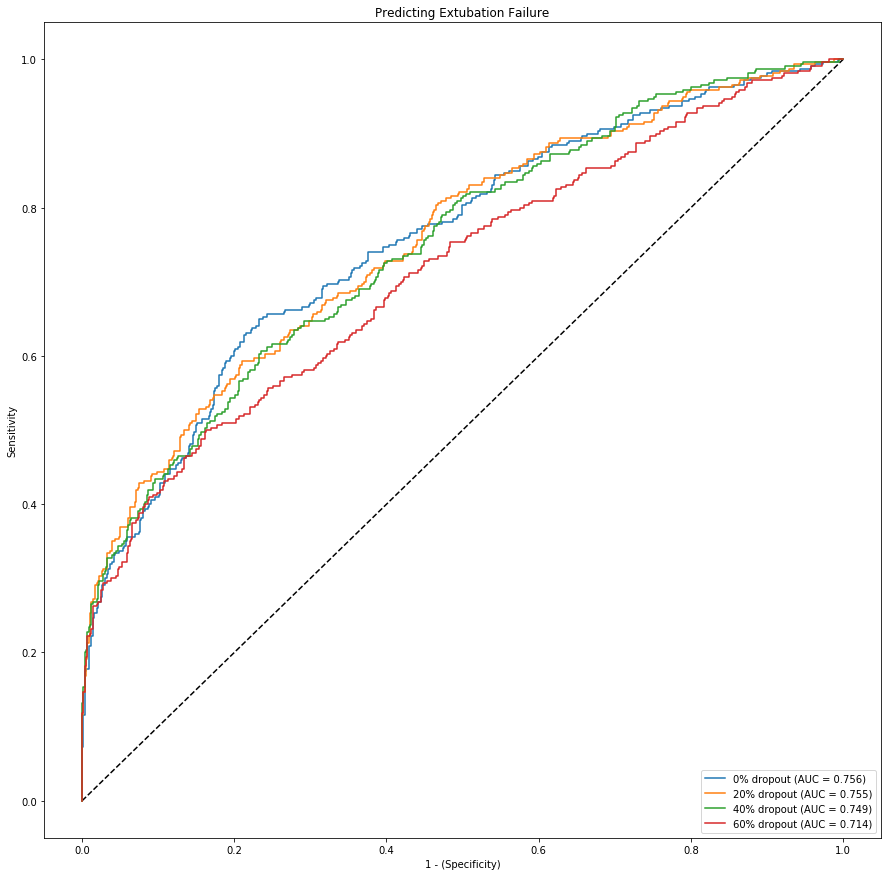

In [96]:
# Compare ROC curves
plt.figure(figsize=(15,15))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_0, tpr_0, label='0% dropout (AUC = {:.3f})'.format(auc_0), ls='-')
plt.plot(fpr_20, tpr_20, label='20% dropout (AUC = {:.3f})'.format(auc_20), ls='-')
plt.plot(fpr_40, tpr_40, label='40% dropout (AUC = {:.3f})'.format(auc_40), ls='-')
plt.plot(fpr_60, tpr_60, label='60% dropout (AUC = {:.3f})'.format(auc_60), ls='-')
plt.xlabel('1 - (Specificity)')
plt.ylabel('Sensitivity')
plt.title('Predicting Extubation Failure')
plt.legend(loc='lower right')
plt.savefig('plots/roc_curves.png', bbox_inches='tight')
plt.show()

# Experiment #3: Epochs

Let the model train for 250 epochs with new parameters to see what happens:
- dropout = 0.1
- learning rate = 0.0001
- batch size = 16

In [97]:
# Define model architecture
model = Sequential()
model.add(GRU(30, return_sequences=True, input_shape=(24,37)))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(40, activation = "sigmoid"))
model.add(Dropout(0.1))
model.add(Dense(1, activation = "sigmoid"))
model.add(BatchNormalization())
model.add((Activation('sigmoid')))

# Compile model
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=[metrics.BinaryAccuracy(), metrics.AUC()])

# Print model summary
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 24, 30)            6120      
_________________________________________________________________
flatten_8 (Flatten)          (None, 720)               0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 720)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 40)                28840     
_________________________________________________________________
dropout_16 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 41        
_________________________________________________________________
batch_normalization_8 (Batch (None, 1)                

In [98]:
# Load the data
_data = np.load('data/ML_data.npy', allow_pickle=True).tolist()
X_train = _data['X_24h_train_norm']
reint_train = _data['reint_24h_train']
y_train = _data['y_24h_train']
X_val = _data['X_24h_val_norm']
y_val = _data['y_24h_val']
reint_val = _data['reint_24h_val']
X_test = _data['X_24h_test_norm']
y_test = _data['y_24h_test']
reint_test = _data['reint_24h_test']
print("Loaded!")

Loaded!


In [99]:
# Print information about data
print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of extubation failures in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of extubation failures in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

No. of patients: 8966
No. of patients in train, val, test sets: 7172, 897, 897
No. of extubation failures in train, val, test sets: 2636.0, 325.0, 320.0
Proportion of extubation failures in train, val, test sets: 36.754%, 36.232%, 35.674%


In [100]:
# Reshape the input tensors so they are in the shape (m,T,n) to fit Keras standards
X_train = np.transpose(X_train, (0,2,1))
X_val = np.transpose(X_val, (0,2,1))
X_test = np.transpose(X_test, (0,2,1))

In [101]:
# Check the shapes of the arrays
print("X_train: {}".format(np.shape(X_train)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val: {}".format(np.shape(X_val)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test: {}".format(np.shape(X_test)))
print("y_test: {}".format(np.shape(y_test)))

X_train: (7172, 24, 37)
y_train: (7172,)
X_val: (897, 24, 37)
y_val: (897,)
X_test: (897, 24, 37)
y_test: (897,)


In [102]:
# Define the early stopping callback
#es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=250, batch_size=32, verbose=1) #, callbacks=[es])

Train on 7172 samples, validate on 897 samples
Epoch 1/250
7172/7172 [==============================] - 4s 513us/step - loss: 0.6829 - binary_accuracy: 0.5947 - auc_8: 0.6406 - val_loss: 0.6554 - val_binary_accuracy: 0.5797 - val_auc_8: 0.7174
Epoch 2/250
7172/7172 [==============================] - 3s 392us/step - loss: 0.6375 - binary_accuracy: 0.6265 - auc_8: 0.6916 - val_loss: 0.5911 - val_binary_accuracy: 0.6912 - val_auc_8: 0.7363
Epoch 3/250
7172/7172 [==============================] - 3s 379us/step - loss: 0.6217 - binary_accuracy: 0.6502 - auc_8: 0.7083 - val_loss: 0.5773 - val_binary_accuracy: 0.7057 - val_auc_8: 0.7422
Epoch 4/250
7172/7172 [==============================] - 3s 409us/step - loss: 0.6081 - binary_accuracy: 0.6695 - auc_8: 0.7190 - val_loss: 0.5655 - val_binary_accuracy: 0.7157 - val_auc_8: 0.7495
Epoch 5/250
7172/7172 [==============================] - 3s 390us/step - loss: 0.5981 - binary_accuracy: 0.6835 - auc_8: 0.7286 - val_loss: 0.5666 - val_binary_accur

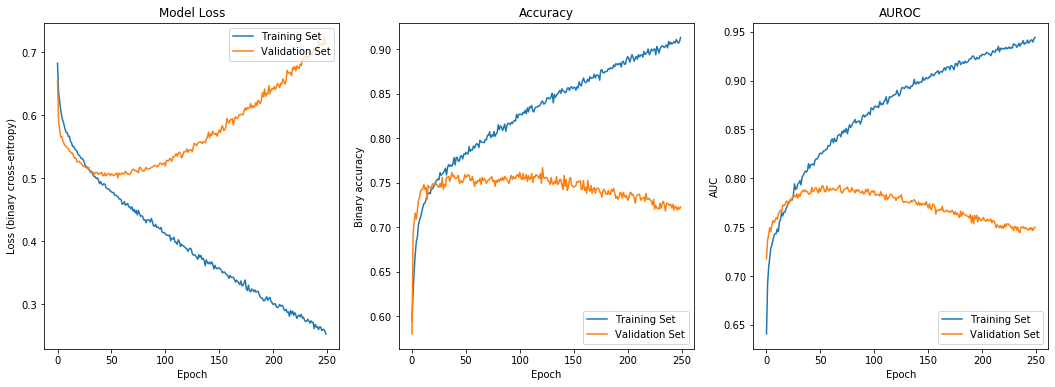

In [103]:
# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(18,6))

# PLot the loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set(title='Model Loss', ylabel='Loss (binary cross-entropy)', xlabel='Epoch')
ax1.legend(['Training Set', 'Validation Set'], loc='upper right')

# Plot the accuracy
ax2.plot(history.history['binary_accuracy'])
ax2.plot(history.history['val_binary_accuracy'])
ax2.set(title='Accuracy', ylabel='Binary accuracy', xlabel='Epoch')
ax2.legend(['Training Set', 'Validation Set'], loc='lower right')

# Plot the AUC
ax3.plot(history.history['auc_8'])
ax3.plot(history.history['val_auc_8'])
ax3.set(title='AUROC', ylabel='AUC', xlabel='Epoch')
ax3.legend(['Training Set', 'Validation Set'], loc='lower right')

#plt.savefig('training.png', bbox_inches='tight')
plt.show()

In [104]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [105]:
# Calculate the accuracy and AUROC for the test set using the RNN
from sklearn.metrics import auc
auroc = auc(fpr, tpr)

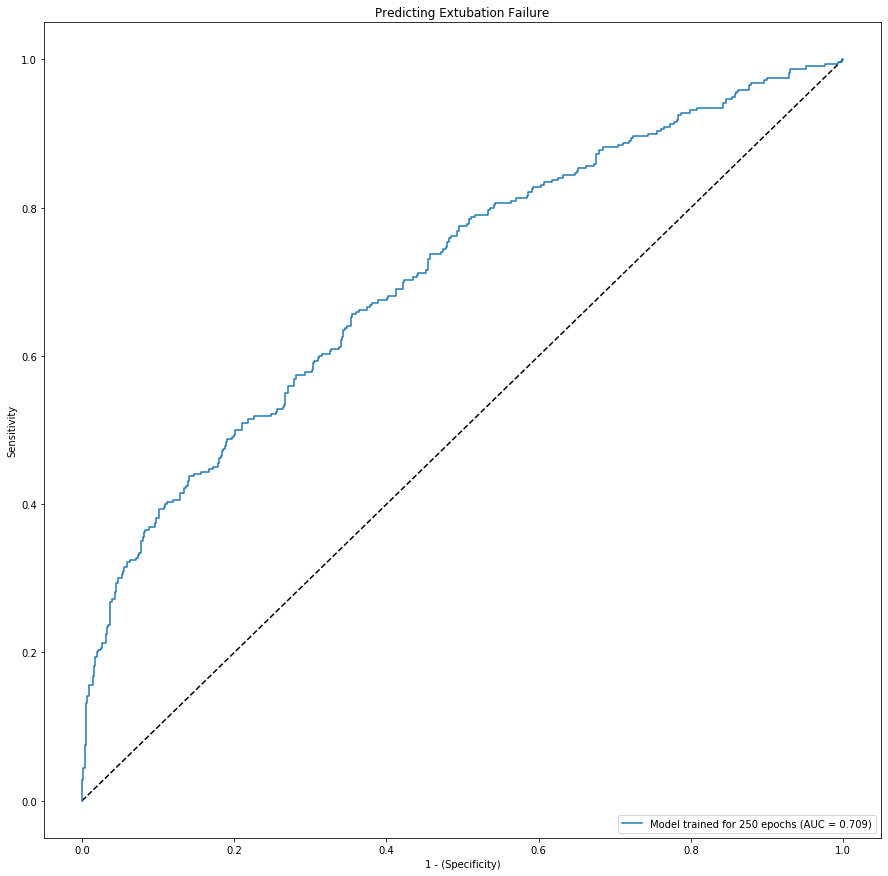

In [106]:
# Compare ROC curves
plt.figure(figsize=(15,15))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Model trained for 250 epochs (AUC = {:.3f})'.format(auroc), ls='-')
plt.xlabel('1 - (Specificity)')
plt.ylabel('Sensitivity')
plt.title('Predicting Extubation Failure')
plt.legend(loc='lower right')
plt.savefig('plots/roc_curves.png', bbox_inches='tight')
plt.show()

# Experiment #4: Regularization

Compare the performance of models with:
- no regularization.
- L1 regularization only.
- L2 regularization only.
- L1 and L2 regularization (elastic net).

In [114]:
# Define model architecture
model = Sequential()
model.add(GRU(30, return_sequences=True, input_shape=(24,37)))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(40, activation = "sigmoid"))
model.add(Dropout(0.1))
model.add(Dense(1, activation = "sigmoid"))
model.add(BatchNormalization())
model.add((Activation('sigmoid')))

# Compile model
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=[metrics.BinaryAccuracy(), metrics.AUC()])

# Print model summary
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, 24, 30)            6120      
_________________________________________________________________
flatten_10 (Flatten)         (None, 720)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 720)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 40)                28840     
_________________________________________________________________
dropout_20 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 41        
_________________________________________________________________
batch_normalization_10 (Batc (None, 1)               

In [115]:
# Load the data
_data = np.load('data/ML_data.npy', allow_pickle=True).tolist()
X_train = _data['X_24h_train_norm']
reint_train = _data['reint_24h_train']
y_train = _data['y_24h_train']
X_val = _data['X_24h_val_norm']
y_val = _data['y_24h_val']
reint_val = _data['reint_24h_val']
X_test = _data['X_24h_test_norm']
y_test = _data['y_24h_test']
reint_test = _data['reint_24h_test']
print("Loaded!")

Loaded!


In [116]:
# Print information about data
print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of extubation failures in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of extubation failures in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

No. of patients: 8966
No. of patients in train, val, test sets: 7172, 897, 897
No. of extubation failures in train, val, test sets: 2636.0, 325.0, 320.0
Proportion of extubation failures in train, val, test sets: 36.754%, 36.232%, 35.674%


In [117]:
# Reshape the input tensors so they are in the shape (m,T,n) to fit Keras standards
X_train = np.transpose(X_train, (0,2,1))
X_val = np.transpose(X_val, (0,2,1))
X_test = np.transpose(X_test, (0,2,1))

In [118]:
# Check the shapes of the arrays
print("X_train: {}".format(np.shape(X_train)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val: {}".format(np.shape(X_val)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test: {}".format(np.shape(X_test)))
print("y_test: {}".format(np.shape(y_test)))

X_train: (7172, 24, 37)
y_train: (7172,)
X_val: (897, 24, 37)
y_val: (897,)
X_test: (897, 24, 37)
y_test: (897,)


In [119]:
# Define the early stopping callback
#es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=50, batch_size=32, verbose=1) #, callbacks=[es])

Train on 7172 samples, validate on 897 samples
Epoch 1/50
7172/7172 [==============================] - 4s 546us/step - loss: 0.6786 - binary_accuracy: 0.6030 - auc_10: 0.6413 - val_loss: 0.6507 - val_binary_accuracy: 0.6276 - val_auc_10: 0.7185
Epoch 2/50
7172/7172 [==============================] - 3s 434us/step - loss: 0.6253 - binary_accuracy: 0.6511 - auc_10: 0.6995 - val_loss: 0.5846 - val_binary_accuracy: 0.7012 - val_auc_10: 0.7339
Epoch 3/50
7172/7172 [==============================] - 3s 396us/step - loss: 0.6091 - binary_accuracy: 0.6659 - auc_10: 0.7118 - val_loss: 0.5669 - val_binary_accuracy: 0.7246 - val_auc_10: 0.7453
Epoch 4/50
7172/7172 [==============================] - 3s 397us/step - loss: 0.5971 - binary_accuracy: 0.6849 - auc_10: 0.7255 - val_loss: 0.5613 - val_binary_accuracy: 0.7324 - val_auc_10: 0.7508
Epoch 5/50
7172/7172 [==============================] - 3s 414us/step - loss: 0.5946 - binary_accuracy: 0.6842 - auc_10: 0.7253 - val_loss: 0.5596 - val_binary_a

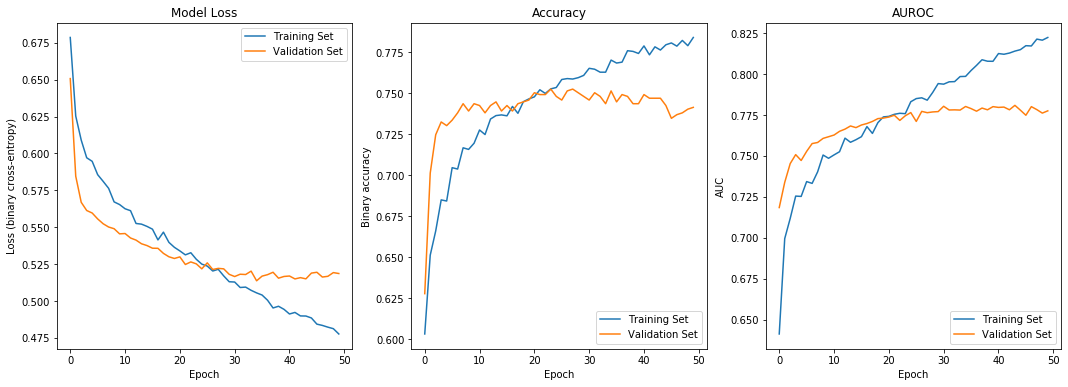

In [121]:
# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(18,6))

# PLot the loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set(title='Model Loss', ylabel='Loss (binary cross-entropy)', xlabel='Epoch')
ax1.legend(['Training Set', 'Validation Set'], loc='upper right')

# Plot the accuracy
ax2.plot(history.history['binary_accuracy'])
ax2.plot(history.history['val_binary_accuracy'])
ax2.set(title='Accuracy', ylabel='Binary accuracy', xlabel='Epoch')
ax2.legend(['Training Set', 'Validation Set'], loc='lower right')

# Plot the AUC
ax3.plot(history.history['auc_10'])
ax3.plot(history.history['val_auc_10'])
ax3.set(title='AUROC', ylabel='AUC', xlabel='Epoch')
ax3.legend(['Training Set', 'Validation Set'], loc='lower right')

#plt.savefig('training.png', bbox_inches='tight')
plt.show()

In [122]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
y_pred_none = model.predict(X_test).ravel()
fpr_none, tpr_none, thresholds_none = roc_curve(y_test, y_pred_none)

In [123]:
# Calculate the accuracy and AUROC for the test set using the RNN
from sklearn.metrics import auc
auc_none = auc(fpr_none, tpr_none)

In [125]:
# Define model architecture
model = Sequential()
model.add(GRU(30, return_sequences=True, input_shape=(24,37), activity_regularizer = regularizers.l1(l=0.1)))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(40, activation = "sigmoid", activity_regularizer = regularizers.l1(l=0.1)))
model.add(Dropout(0.1))
model.add(Dense(1, activation = "sigmoid", activity_regularizer = regularizers.l1(l=0.1)))
model.add(BatchNormalization())
model.add((Activation('sigmoid')))

# Compile model
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=[metrics.BinaryAccuracy(), metrics.AUC()])

# Print model summary
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_11 (GRU)                 (None, 24, 30)            6120      
_________________________________________________________________
flatten_11 (Flatten)         (None, 720)               0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 720)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 40)                28840     
_________________________________________________________________
dropout_22 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 41        
_________________________________________________________________
batch_normalization_11 (Batc (None, 1)               

In [126]:
# Define the early stopping callback
#es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=50, batch_size=32, verbose=1) #, callbacks=[es])

Train on 7172 samples, validate on 897 samples
Epoch 1/50
7172/7172 [==============================] - 4s 565us/step - loss: 951.9799 - binary_accuracy: 0.5442 - auc_11: 0.5532 - val_loss: 897.1637 - val_binary_accuracy: 0.5909 - val_auc_11: 0.6327
Epoch 2/50
7172/7172 [==============================] - 3s 407us/step - loss: 846.3578 - binary_accuracy: 0.5616 - auc_11: 0.5694 - val_loss: 792.5782 - val_binary_accuracy: 0.6689 - val_auc_11: 0.6406
Epoch 3/50
7172/7172 [==============================] - 3s 404us/step - loss: 742.1005 - binary_accuracy: 0.5517 - auc_11: 0.5598 - val_loss: 689.1395 - val_binary_accuracy: 0.6187 - val_auc_11: 0.6061
Epoch 4/50
7172/7172 [==============================] - 3s 398us/step - loss: 638.9104 - binary_accuracy: 0.5420 - auc_11: 0.5388 - val_loss: 587.0923 - val_binary_accuracy: 0.6009 - val_auc_11: 0.5723
Epoch 5/50
7172/7172 [==============================] - 3s 403us/step - loss: 537.5563 - binary_accuracy: 0.5266 - auc_11: 0.5211 - val_loss: 487

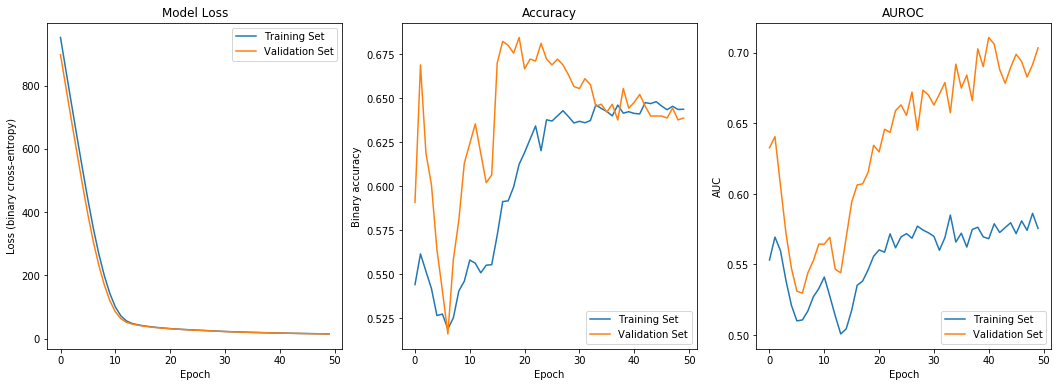

In [127]:
# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(18,6))

# PLot the loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set(title='Model Loss', ylabel='Loss (binary cross-entropy)', xlabel='Epoch')
ax1.legend(['Training Set', 'Validation Set'], loc='upper right')

# Plot the accuracy
ax2.plot(history.history['binary_accuracy'])
ax2.plot(history.history['val_binary_accuracy'])
ax2.set(title='Accuracy', ylabel='Binary accuracy', xlabel='Epoch')
ax2.legend(['Training Set', 'Validation Set'], loc='lower right')

# Plot the AUC
ax3.plot(history.history['auc_11'])
ax3.plot(history.history['val_auc_11'])
ax3.set(title='AUROC', ylabel='AUC', xlabel='Epoch')
ax3.legend(['Training Set', 'Validation Set'], loc='lower right')

#plt.savefig('training.png', bbox_inches='tight')
plt.show()

In [128]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
y_pred_l1 = model.predict(X_test).ravel()
fpr_l1, tpr_l1, thresholds_l1 = roc_curve(y_test, y_pred_l1)

In [129]:
# Calculate the accuracy and AUROC for the test set using the RNN
from sklearn.metrics import auc
auc_l1 = auc(fpr_l1, tpr_l1)

In [142]:
# Define model architecture
model = Sequential()
model.add(GRU(30, return_sequences=True, input_shape=(24,37), activity_regularizer = regularizers.l2(l=0.1)))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(40, activation = "sigmoid", activity_regularizer = regularizers.l2(l=0.1)))
model.add(Dropout(0.1))
model.add(Dense(1, activation = "sigmoid", activity_regularizer = regularizers.l2(l=0.1)))
model.add(BatchNormalization())
model.add((Activation('sigmoid')))

# Compile model
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=[metrics.BinaryAccuracy(), metrics.AUC()])

# Print model summary
print(model.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_14 (GRU)                 (None, 24, 30)            6120      
_________________________________________________________________
flatten_14 (Flatten)         (None, 720)               0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 720)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 40)                28840     
_________________________________________________________________
dropout_28 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 41        
_________________________________________________________________
batch_normalization_14 (Batc (None, 1)               

In [143]:
# Define the early stopping callback
#es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=250, batch_size=32, verbose=1) #, callbacks=[es])

Train on 7172 samples, validate on 897 samples
Epoch 1/250
7172/7172 [==============================] - 8s 1ms/step - loss: 542.7977 - binary_accuracy: 0.5310 - auc_14: 0.5600 - val_loss: 490.4332 - val_binary_accuracy: 0.4638 - val_auc_14: 0.6683
Epoch 2/250
7172/7172 [==============================] - 9s 1ms/step - loss: 442.6531 - binary_accuracy: 0.5562 - auc_14: 0.5847 - val_loss: 396.6905 - val_binary_accuracy: 0.7057 - val_auc_14: 0.6932 loss: 455.3493 
Epoch 3/250
7172/7172 [==============================] - 6s 831us/step - loss: 354.7078 - binary_accuracy: 0.5676 - auc_14: 0.5895 - val_loss: 314.6941 - val_binary_accuracy: 0.6912 - val_auc_14: 0.6892
Epoch 4/250
7172/7172 [==============================] - 10s 1ms/step - loss: 278.6581 - binary_accuracy: 0.5619 - auc_14: 0.5766 - val_loss: 244.6635 - val_binary_accuracy: 0.6845 - val_auc_14: 0.6542
Epoch 5/250
7172/7172 [==============================] - 6s 885us/step - loss: 213.7740 - binary_accuracy: 0.5595 - auc_14: 0.5643

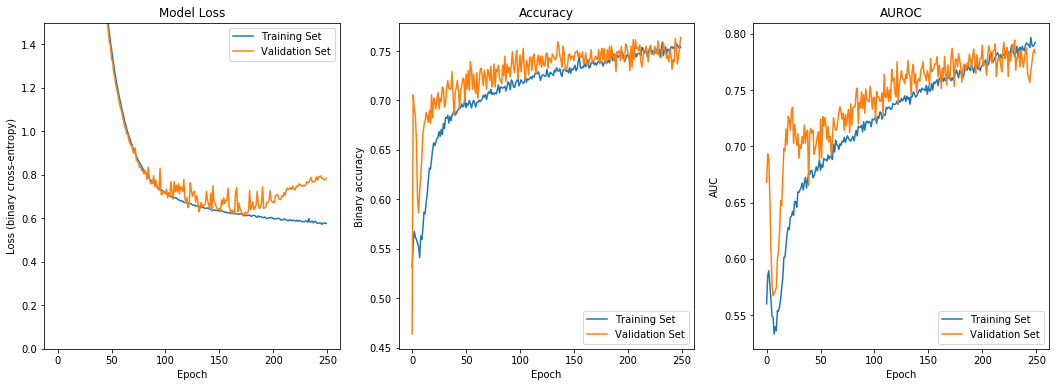

In [151]:
# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(18,6))

# PLot the loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set(title='Model Loss', ylabel='Loss (binary cross-entropy)', xlabel='Epoch')
ax1.set_ylim((0,1.5))
ax1.legend(['Training Set', 'Validation Set'], loc='upper right')

# Plot the accuracy
ax2.plot(history.history['binary_accuracy'])
ax2.plot(history.history['val_binary_accuracy'])
ax2.set(title='Accuracy', ylabel='Binary accuracy', xlabel='Epoch')
ax2.legend(['Training Set', 'Validation Set'], loc='lower right')

# Plot the AUC
ax3.plot(history.history['auc_14'])
ax3.plot(history.history['val_auc_14'])
ax3.set(title='AUROC', ylabel='AUC', xlabel='Epoch')
ax3.legend(['Training Set', 'Validation Set'], loc='lower right')

#plt.savefig('training.png', bbox_inches='tight')
plt.show()

In [146]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
y_pred_l2 = model.predict(X_test).ravel()
fpr_l2, tpr_l2, thresholds_l2 = roc_curve(y_test, y_pred_l2)

In [147]:
# Calculate the accuracy and AUROC for the test set using the RNN
from sklearn.metrics import auc
auc_l2 = auc(fpr_l2, tpr_l2)

In [148]:
print(auc_l2)

0.7434900346620451


In [135]:
# Define model architecture
model = Sequential()
model.add(GRU(30, return_sequences=True, input_shape=(24,37), activity_regularizer = regularizers.l1_l2(l1=0.1,l2=0.1)))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(40, activation = "sigmoid", activity_regularizer = regularizers.l1_l2(l1=0.1,l2=0.1)))
model.add(Dropout(0.1))
model.add(Dense(1, activation = "sigmoid", activity_regularizer = regularizers.l1_l2(l1=0.1,l2=0.1)))
model.add(BatchNormalization())
model.add((Activation('sigmoid')))

# Compile model
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=[metrics.BinaryAccuracy(), metrics.AUC()])

# Print model summary
print(model.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_13 (GRU)                 (None, 24, 30)            6120      
_________________________________________________________________
flatten_13 (Flatten)         (None, 720)               0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 720)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 40)                28840     
_________________________________________________________________
dropout_26 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 41        
_________________________________________________________________
batch_normalization_13 (Batc (None, 1)               

In [136]:
# Define the early stopping callback
#es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=50, batch_size=32, verbose=1) #, callbacks=[es])

Train on 7172 samples, validate on 897 samples
Epoch 1/50
7172/7172 [==============================] - 4s 613us/step - loss: 1471.2176 - binary_accuracy: 0.5006 - auc_13: 0.5097 - val_loss: 1366.1806 - val_binary_accuracy: 0.4281 - val_auc_13: 0.5794
Epoch 2/50
7172/7172 [==============================] - 3s 453us/step - loss: 1271.8910 - binary_accuracy: 0.5233 - auc_13: 0.5394 - val_loss: 1175.3998 - val_binary_accuracy: 0.6555 - val_auc_13: 0.5993
Epoch 3/50
7172/7172 [==============================] - 4s 515us/step - loss: 1085.9395 - binary_accuracy: 0.5328 - auc_13: 0.5331 - val_loss: 997.0914 - val_binary_accuracy: 0.6455 - val_auc_13: 0.5993
Epoch 4/50
7172/7172 [==============================] - 4s 493us/step - loss: 912.4156 - binary_accuracy: 0.5300 - auc_13: 0.5305 - val_loss: 831.3953 - val_binary_accuracy: 0.6366 - val_auc_13: 0.5732
Epoch 5/50
7172/7172 [==============================] - 3s 469us/step - loss: 752.5494 - binary_accuracy: 0.5187 - auc_13: 0.5057 - val_loss

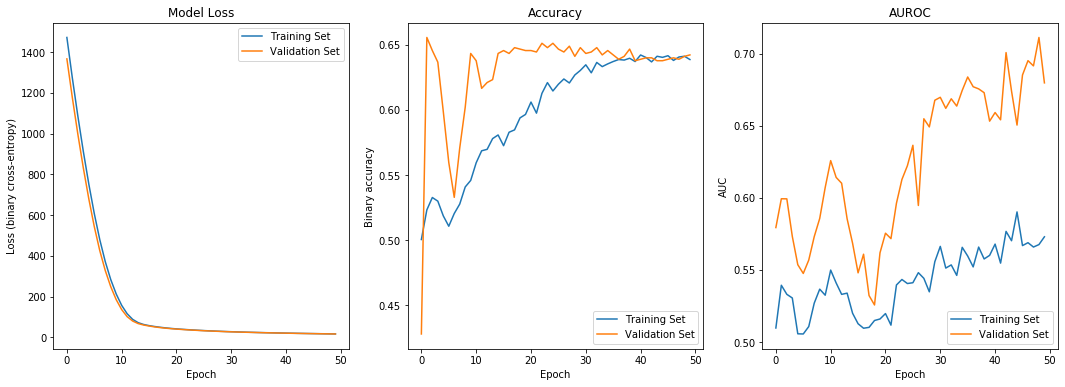

In [138]:
# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(18,6))

# PLot the loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set(title='Model Loss', ylabel='Loss (binary cross-entropy)', xlabel='Epoch')
ax1.legend(['Training Set', 'Validation Set'], loc='upper right')

# Plot the accuracy
ax2.plot(history.history['binary_accuracy'])
ax2.plot(history.history['val_binary_accuracy'])
ax2.set(title='Accuracy', ylabel='Binary accuracy', xlabel='Epoch')
ax2.legend(['Training Set', 'Validation Set'], loc='lower right')

# Plot the AUC
ax3.plot(history.history['auc_13'])
ax3.plot(history.history['val_auc_13'])
ax3.set(title='AUROC', ylabel='AUC', xlabel='Epoch')
ax3.legend(['Training Set', 'Validation Set'], loc='lower right')

#plt.savefig('training.png', bbox_inches='tight')
plt.show()

In [139]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
y_pred_l1l2 = model.predict(X_test).ravel()
fpr_l1l2, tpr_l1l2, thresholds_l1l2 = roc_curve(y_test, y_pred_l1l2)

In [140]:
# Calculate the accuracy and AUROC for the test set using the RNN
from sklearn.metrics import auc
auc_l1l2 = auc(fpr_l1l2, tpr_l1l2)

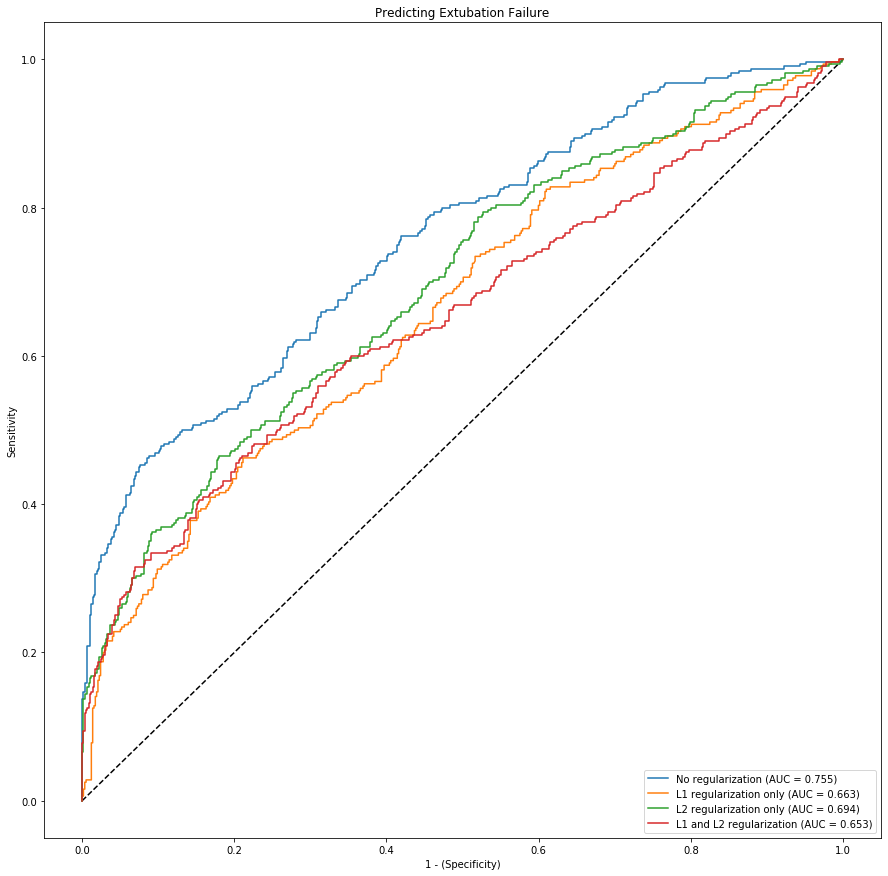

In [141]:
# Compare ROC curves
plt.figure(figsize=(15,15))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_none, tpr_none, label='No regularization (AUC = {:.3f})'.format(auc_none), ls='-')
plt.plot(fpr_l1, tpr_l1, label='L1 regularization only (AUC = {:.3f})'.format(auc_l1), ls='-')
plt.plot(fpr_l2, tpr_l2, label='L2 regularization only (AUC = {:.3f})'.format(auc_l2), ls='-')
plt.plot(fpr_l1l2, tpr_l1l2, label='L1 and L2 regularization (AUC = {:.3f})'.format(auc_l1l2), ls='-')
plt.xlabel('1 - (Specificity)')
plt.ylabel('Sensitivity')
plt.title('Predicting Extubation Failure')
plt.legend(loc='lower right')
plt.savefig('plots/roc_curves.png', bbox_inches='tight')
plt.show()